# Code to compare episodic reward for sample efficiency

In [61]:
from pathlib import Path
import re

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", font_scale=1.1, palette="Set2")
plt.rcParams['figure.dpi'] = 300


## Function Definitions

In [64]:
_STEP_REGEX   = re.compile(r"\b(step|timestep|steps|total_steps|global_step)\b", re.I)
_REWARD_REGEX = re.compile(r"(reward|return|score)", re.I)

def _read_log(path: Path ) -> pd.DataFrame:
    """Load *path* and return a DataFrame with columns [step, reward]."""

    if path.suffix.lower() in {".csv", ".txt"}:
        df = pd.read_csv(path)
    elif path.suffix.lower() == ".jsonl" or path.suffix.lower() == ".json":
        df = pd.read_json(path, lines=True)
    else:
        raise ValueError(f"{path}: unsupported file type")

    # Auto-detect columns if none supplied
    step_col = next((c for c in df.columns if _STEP_REGEX.search(c)), None)
    reward_col = next((c for c in df.columns if _REWARD_REGEX.search(c)), None)

    if step_col is None or reward_col is None:
        raise ValueError(
            f"{path}: couldn’t find both a step-like and reward/score-like column.\n"
            "Use --step-col and/or --reward-col to specify them."
        )

    return df[[step_col, reward_col]].rename(columns={step_col: "step",
                                                      reward_col: "reward"})


def _smooth(series: pd.Series, window: int) -> pd.Series:
    """Rolling mean for visual smoothing."""
    return series.rolling(window, min_periods=1).mean() if window > 1 else series

def _bin(df: pd.DataFrame, bin_size: int = 1):
    if bin_size == 1:
        return df.rename(columns={"step": "step_mid"})   # identity

    bins = range(0, df["step"].max() + bin_size, bin_size)
    df_binned = (df
                .groupby(pd.cut(df["step"], bins))
                .reward
                .mean()
                .reset_index())
    df_binned["step_mid"] = df_binned["step"].apply(lambda iv: iv.mid)
    return df_binned

def plot(files_labels=[], bin_size=1, output=None):
    plt.figure(figsize=(10, 6))

    for path, label in files_labels:
        df = _read_log(Path(path))
        df_binned = _bin(df, bin_size=bin_size)  # Bin the data for better visualization
        sns.lineplot(x=df_binned["step_mid"], y=df_binned["reward"], label=label, linewidth=1.3)

    plt.xlabel("Environment steps")
    plt.ylabel("Episodic reward")
    plt.title(f"RL learning curves (Bin Size: {bin_size})")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    if output:
        plt.savefig(output, dpi=300)
        print(f"Saved figure → {output}")

## Plots

/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_38295/562118821.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.cut(df["step"], bins))
/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_38295/562118821.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.cut(df["step"], bins))
/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_38295/562118821.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defaul

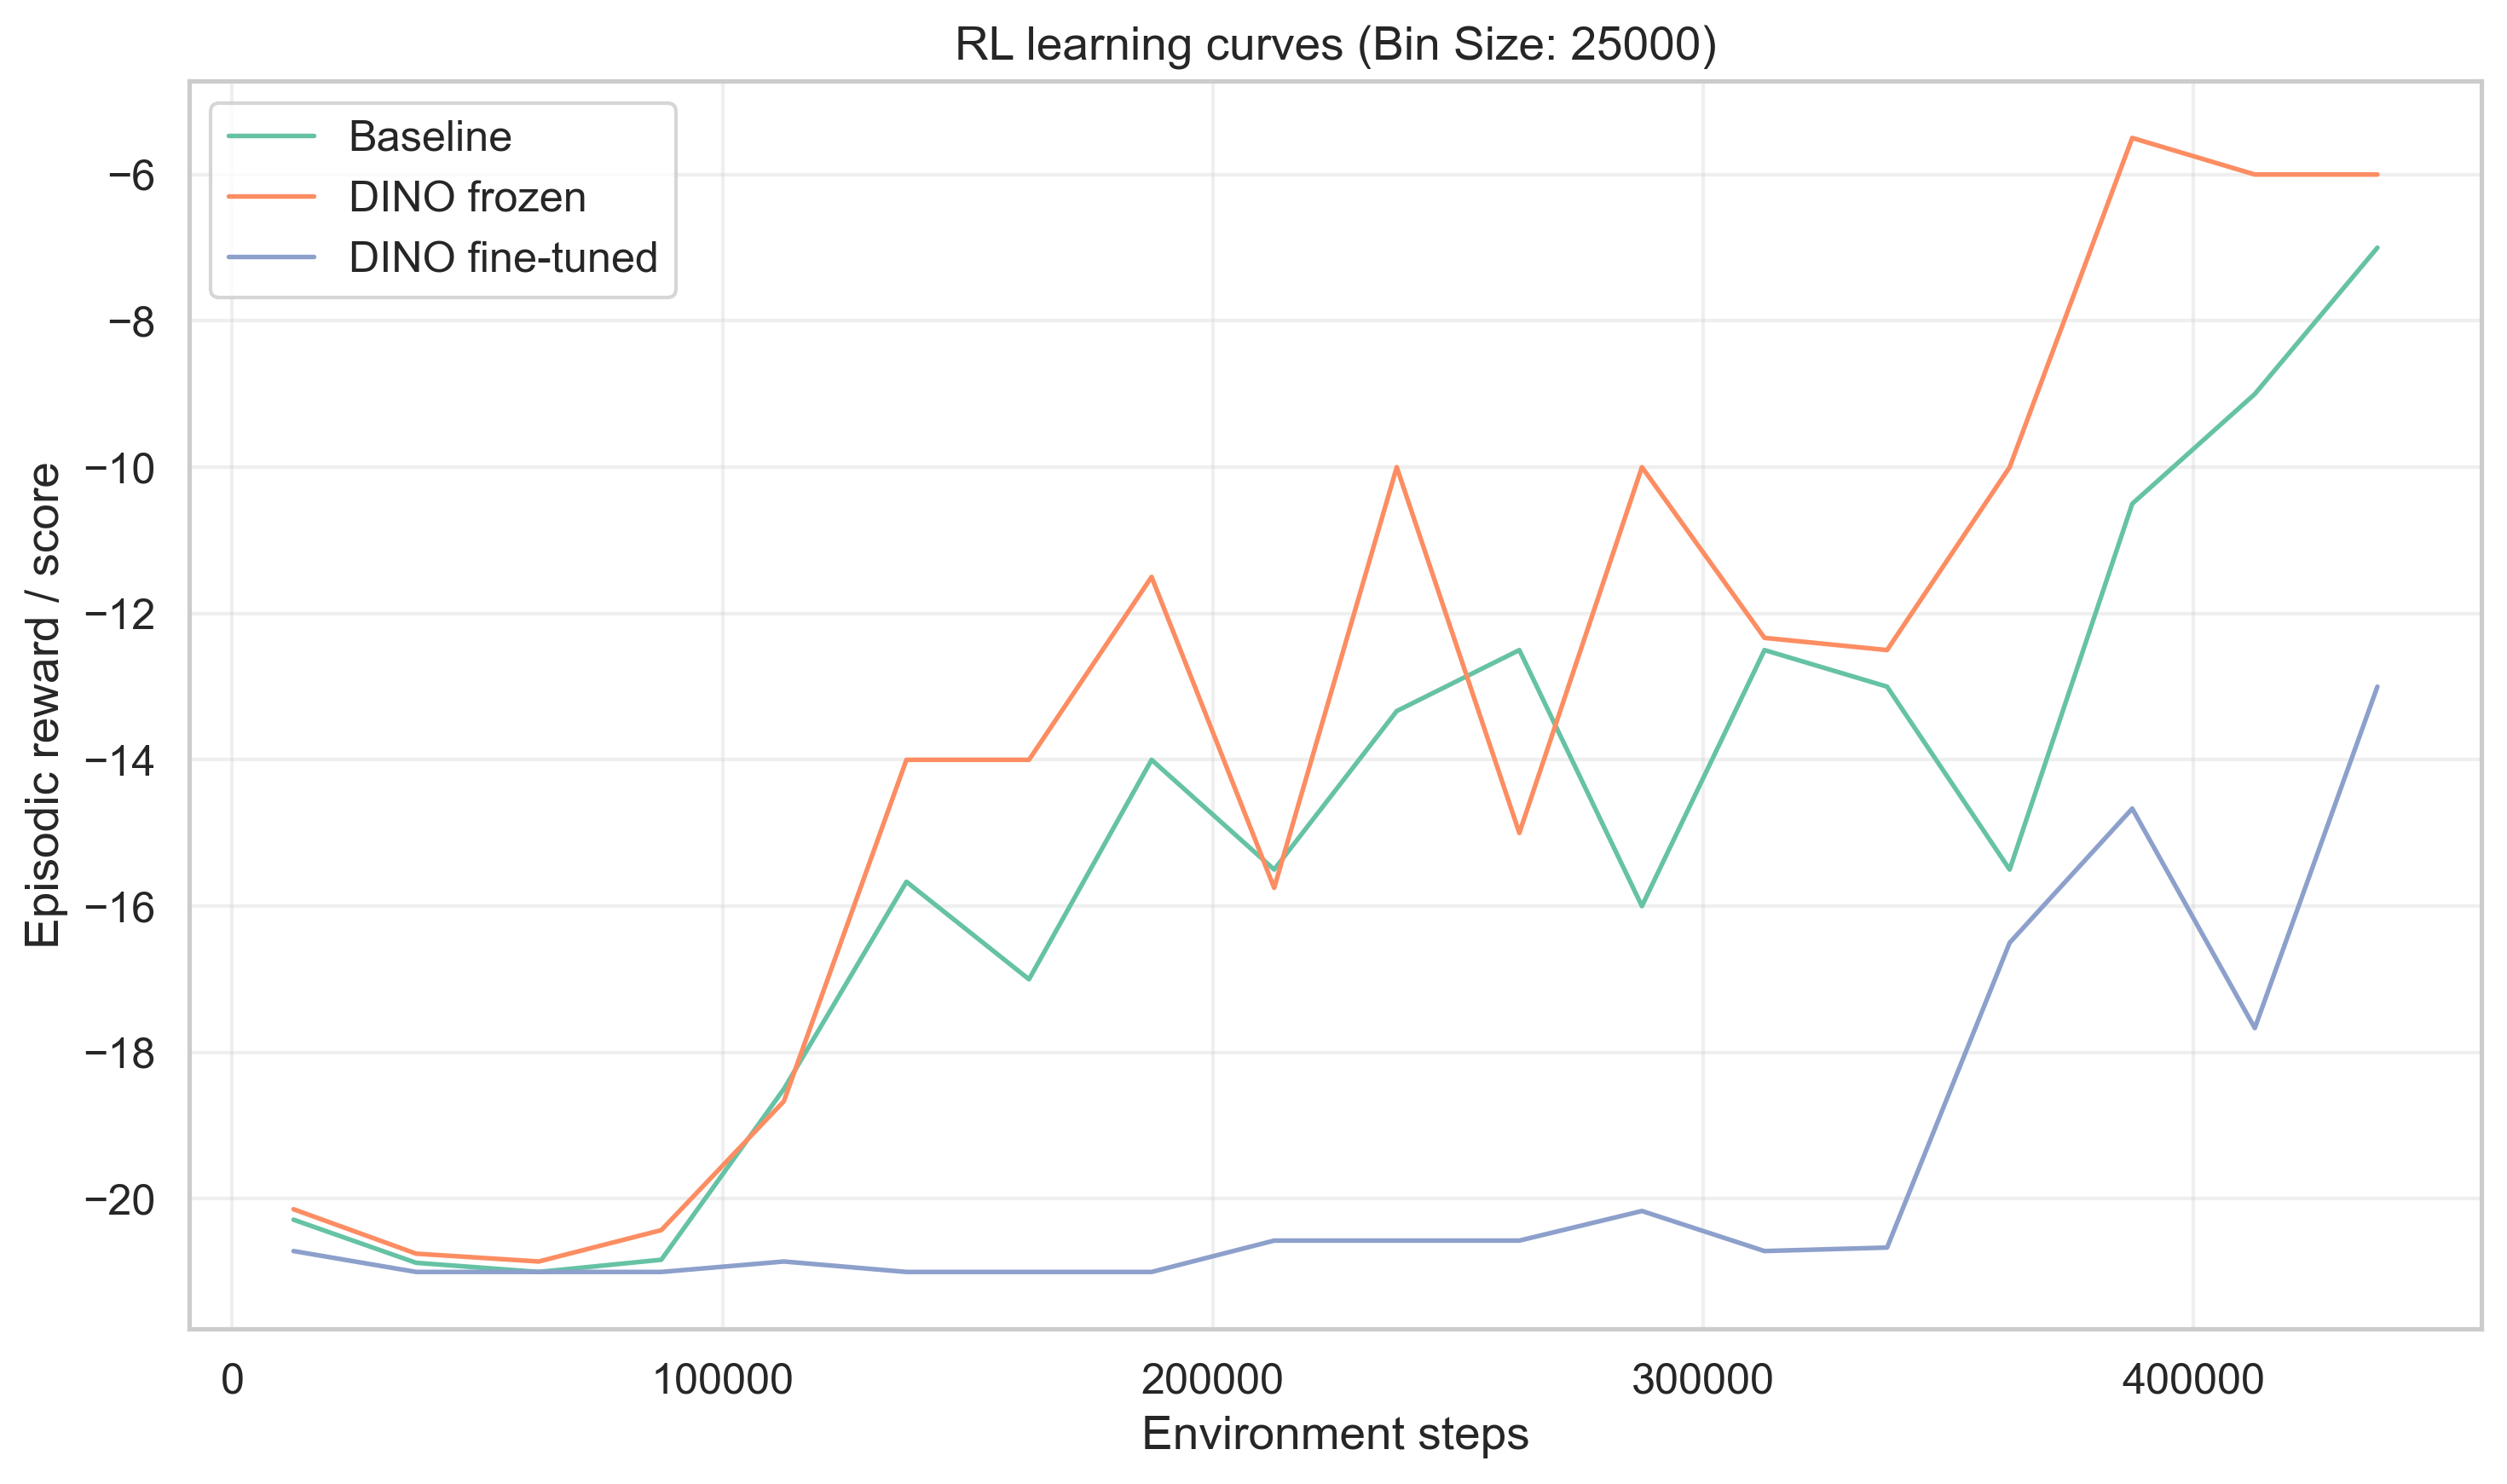

In [58]:
plot(
    files_labels=[
        ("./logdir/pong/pong_baseline/scores.jsonl", "Baseline"),
        ("./logdir/pong/pong_DINO_frozen/scores.jsonl", "DINO frozen"),
        ("./logdir/pong/pong_DINO_ft/scores.jsonl", "DINO fine-tuned"),
    ],
    bin_size=25000
)

/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_38295/453037516.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.cut(df["step"], bins))
/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_38295/453037516.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.cut(df["step"], bins))
/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_38295/453037516.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defaul

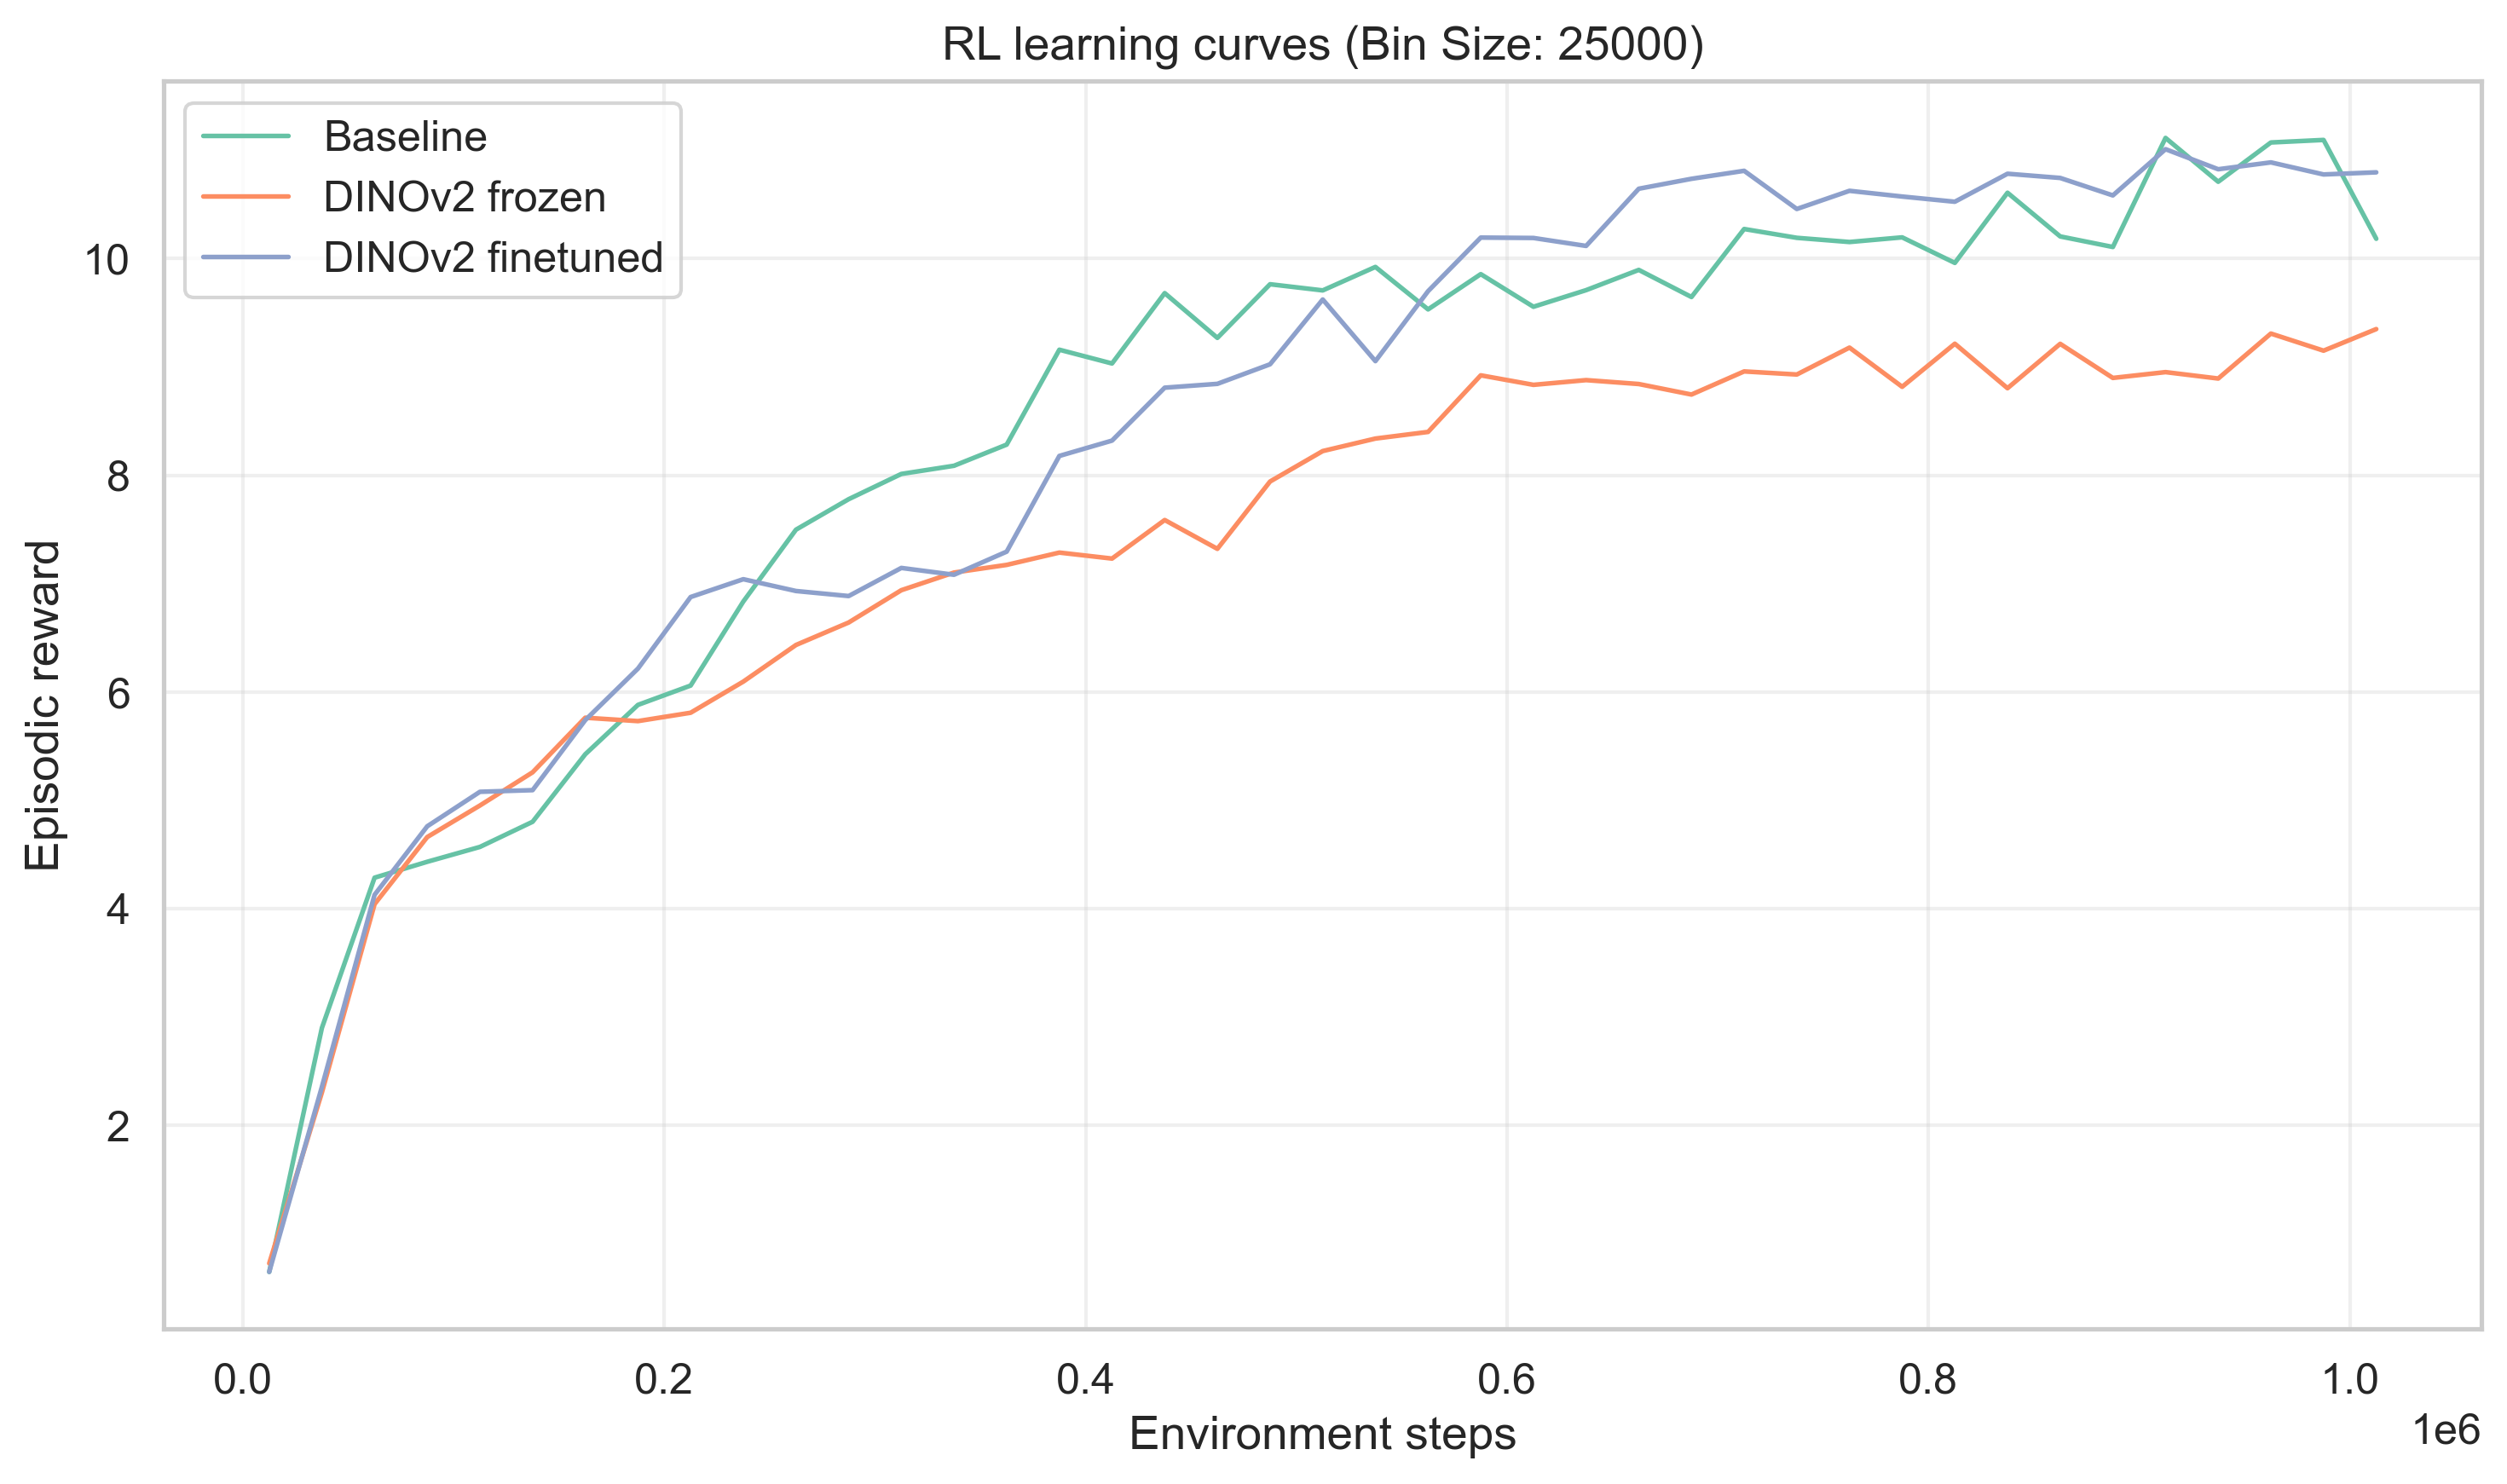

In [66]:
plot(
    files_labels=[
        ("./logdir/baseline_pick_ycb_train_ID/scores.jsonl", "Baseline"),
        ("./logdir/DINOFreeze_pick_ycb_train_ID/scores.jsonl", "DINOv2 frozen"),
        ("./logdir/DINOFT_pick_ycb_train_ID/scores.jsonl", "DINOv2 finetuned"),
    ],
    bin_size=25000
)